In [1]:
suppressMessages(library(rwwa))

# Fit pointwise trends

In [2]:
# load covariate data
gmst = read.table("gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2025]

# define factual & counterfactual covariates
cov_2024 <- gmst[gmst$year == 2025,"gmst", drop = F]
cov_cf <- rbind("pi" = cov_2024 - 1.3)

model_args <- list("dsr5x" = list(dist = "gev", type = "shift", lower = F),
                   "dsr10x" = list(dist = "gev", type = "shift", lower = F),
                   "t2m-jja" = list(dist = "norm", type = "shift", lower = F),
                   "tmax-jja" = list(dist = "norm", type = "shift", lower = F),
                   "tp-jja" = list(dist = "norm_logt", type = "shift", lower = T),
                   "logtp-jja" = list(dist = "norm", type = "shift", lower = T))

In [7]:
for(varnm in c("dsr10x","dsr5x", "t2m-jja", "tmax-jja", "tp-jja", "logtp-jja")[5]) {

    mdl_args <- model_args[[varnm]]
    
    fnm <- paste0("pointwise/",varnm,"-flattened_era5.csv")
    res_fnm <- gsub("flattened", paste0("flattened-res-",gsub("_","",mdl_args$dist)), fnm)
    
    if (!file.exists(res_fnm)) {
        
        # load data
        df <- read.csv(fnm, skip = 3, header = F)
        colnames(df)[1] <- "year"
        df <- merge(gmst, df)

        # convert seasonal rainfall from daily mean rate to seasonal total
        if (varnm == "tp-jja") df[,-(1:2)] <- df[,-(1:2)] * 92 

        # fit nonstationary model to all columns
        models <- sapply(colnames(df)[grepl("V", colnames(df))], function(cnm) {
            df_c <- df[,c("year", "gmst", cnm)]
            tryCatch({
                do.call(fit_ns, append(mdl_args, list("data" = df_c, "covnm" = "gmst", "varnm" = cnm)))
            }, error = function(cond) { return(NULL) })
        }, simplify = F)
        
        # get all model results & save as .csv to be reconstructed & plotted in python
        fitted_res <- sapply(models, function(mdl) {
            if(!is.null(unlist(mdl)[1])) {
                mdl_ests(mdl, cov_f = cov_2024, cov_cf = cov_cf)
            } else {
                rep(NA, 11)
            }})
        write.csv(fitted_res, res_fnm)
    }
}

In [8]:
res_fnm

[1] "pointwise/tp-jja-flattened-res-normlogt_era5.csv"

# JJA precip

In [7]:
ts = read.csv("data/ts_tp-jja_era5_1950-2025.csv")

# load covariate data
gmst = read.table("gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2025]

# define factual & counterfactual covariates
cov_2024 <- gmst[gmst$year == 2025,"gmst", drop = F]
cov_cf <- rbind("pi" = cov_2024 - 1.3)

df <- merge(gmst, ts)
df$tp <- df$tp * 92

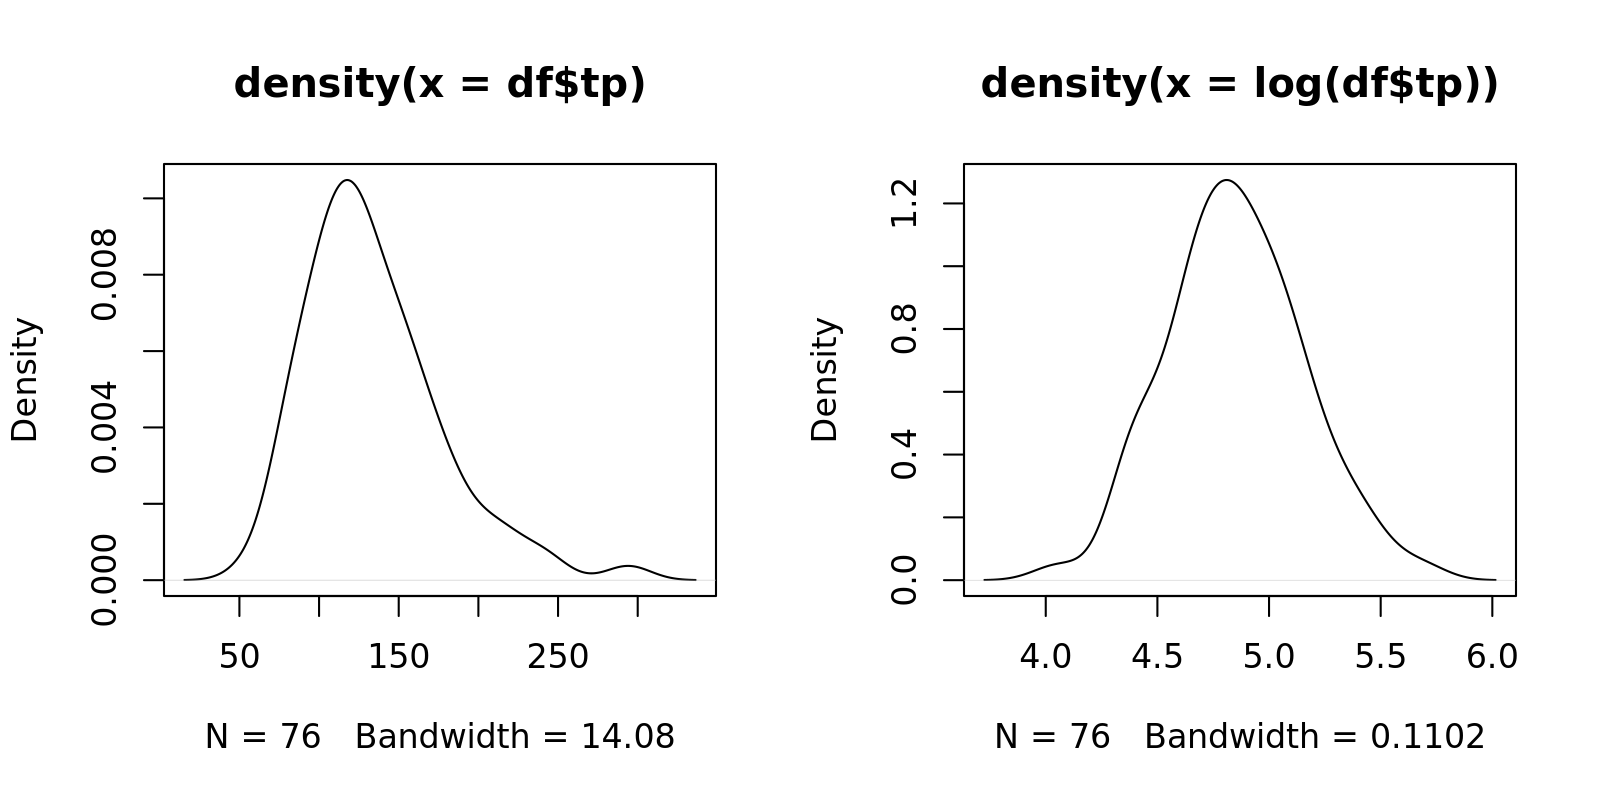

In [8]:
prep_window(c(1,2))

plot(density(df$tp))
plot(density(log(df$tp)))

In [9]:
mdl <- fit_ns("norm_logt", "shift", data = df, varnm = "tp", covnm = "gmst", lower = T)

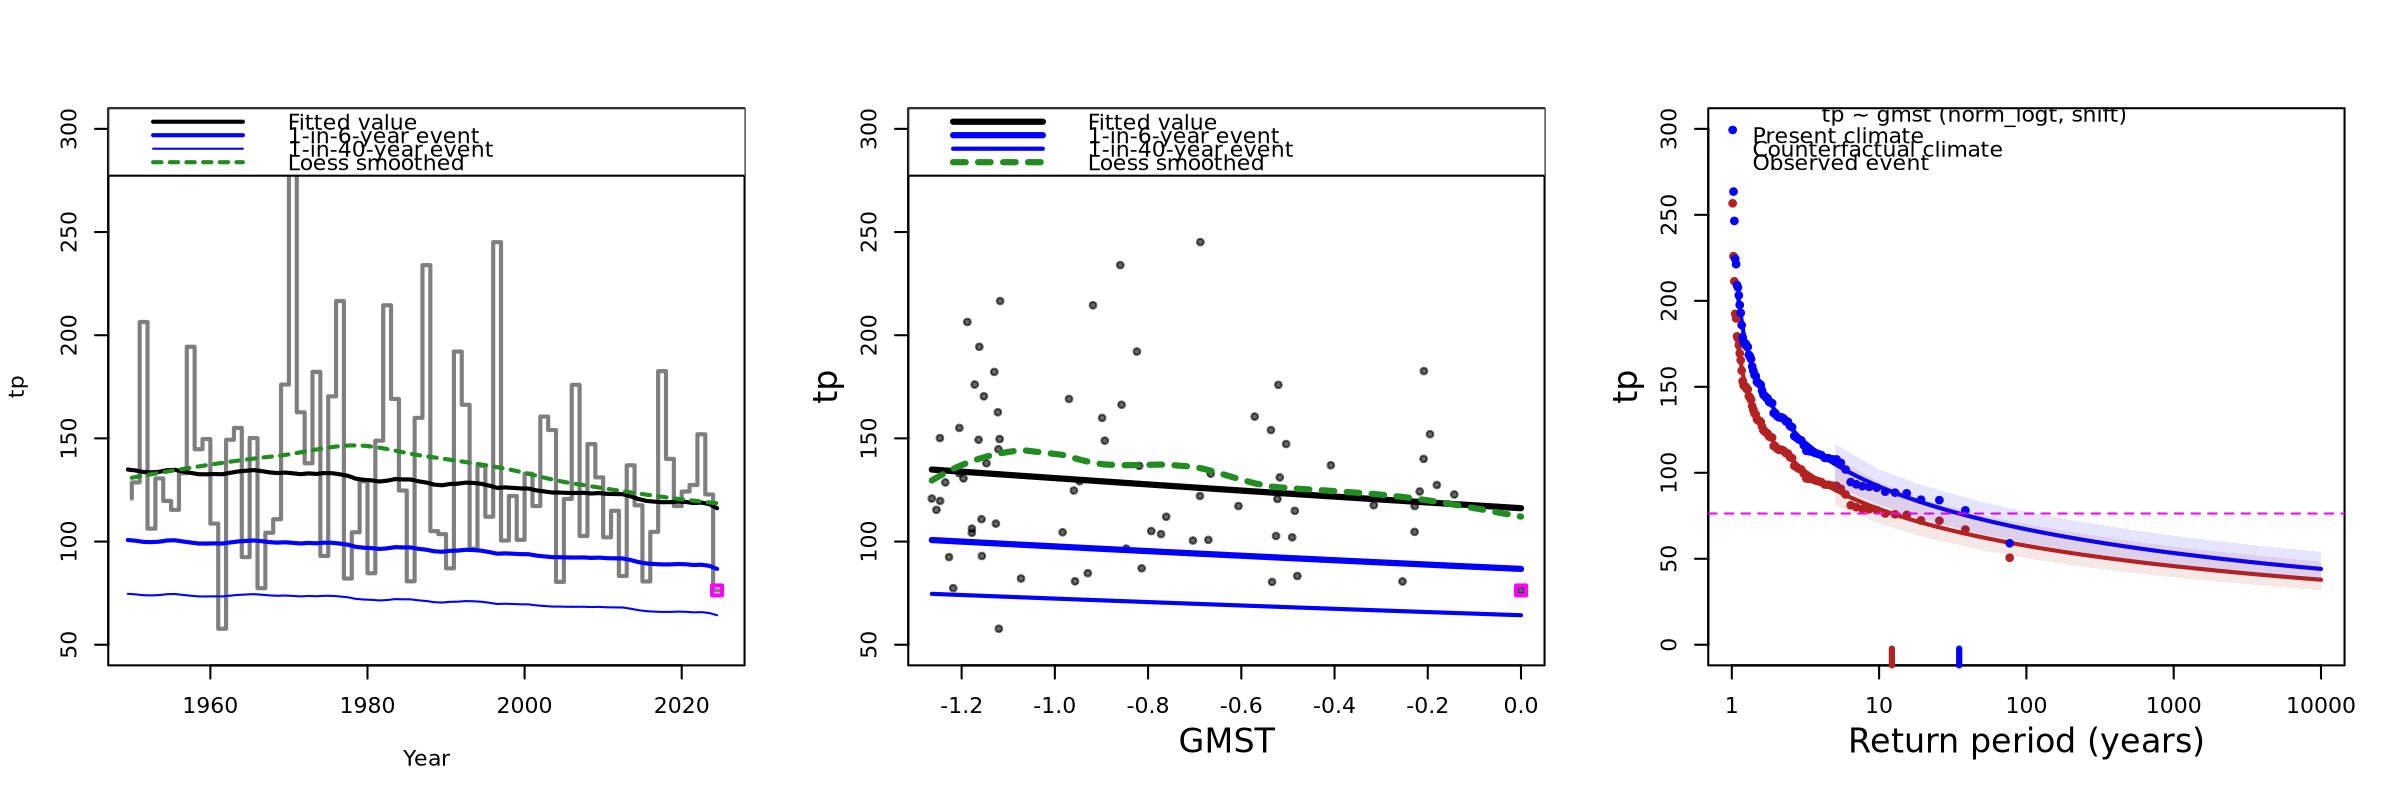

In [10]:
prep_window(c(1,3))

plot_trend(mdl)
plot_covtrend(mdl, "gmst")
plot_returnlevels(mdl, cov_f = cov_2024, cov_cf = cov_cf, nsamp = 50)


## Compare model fits

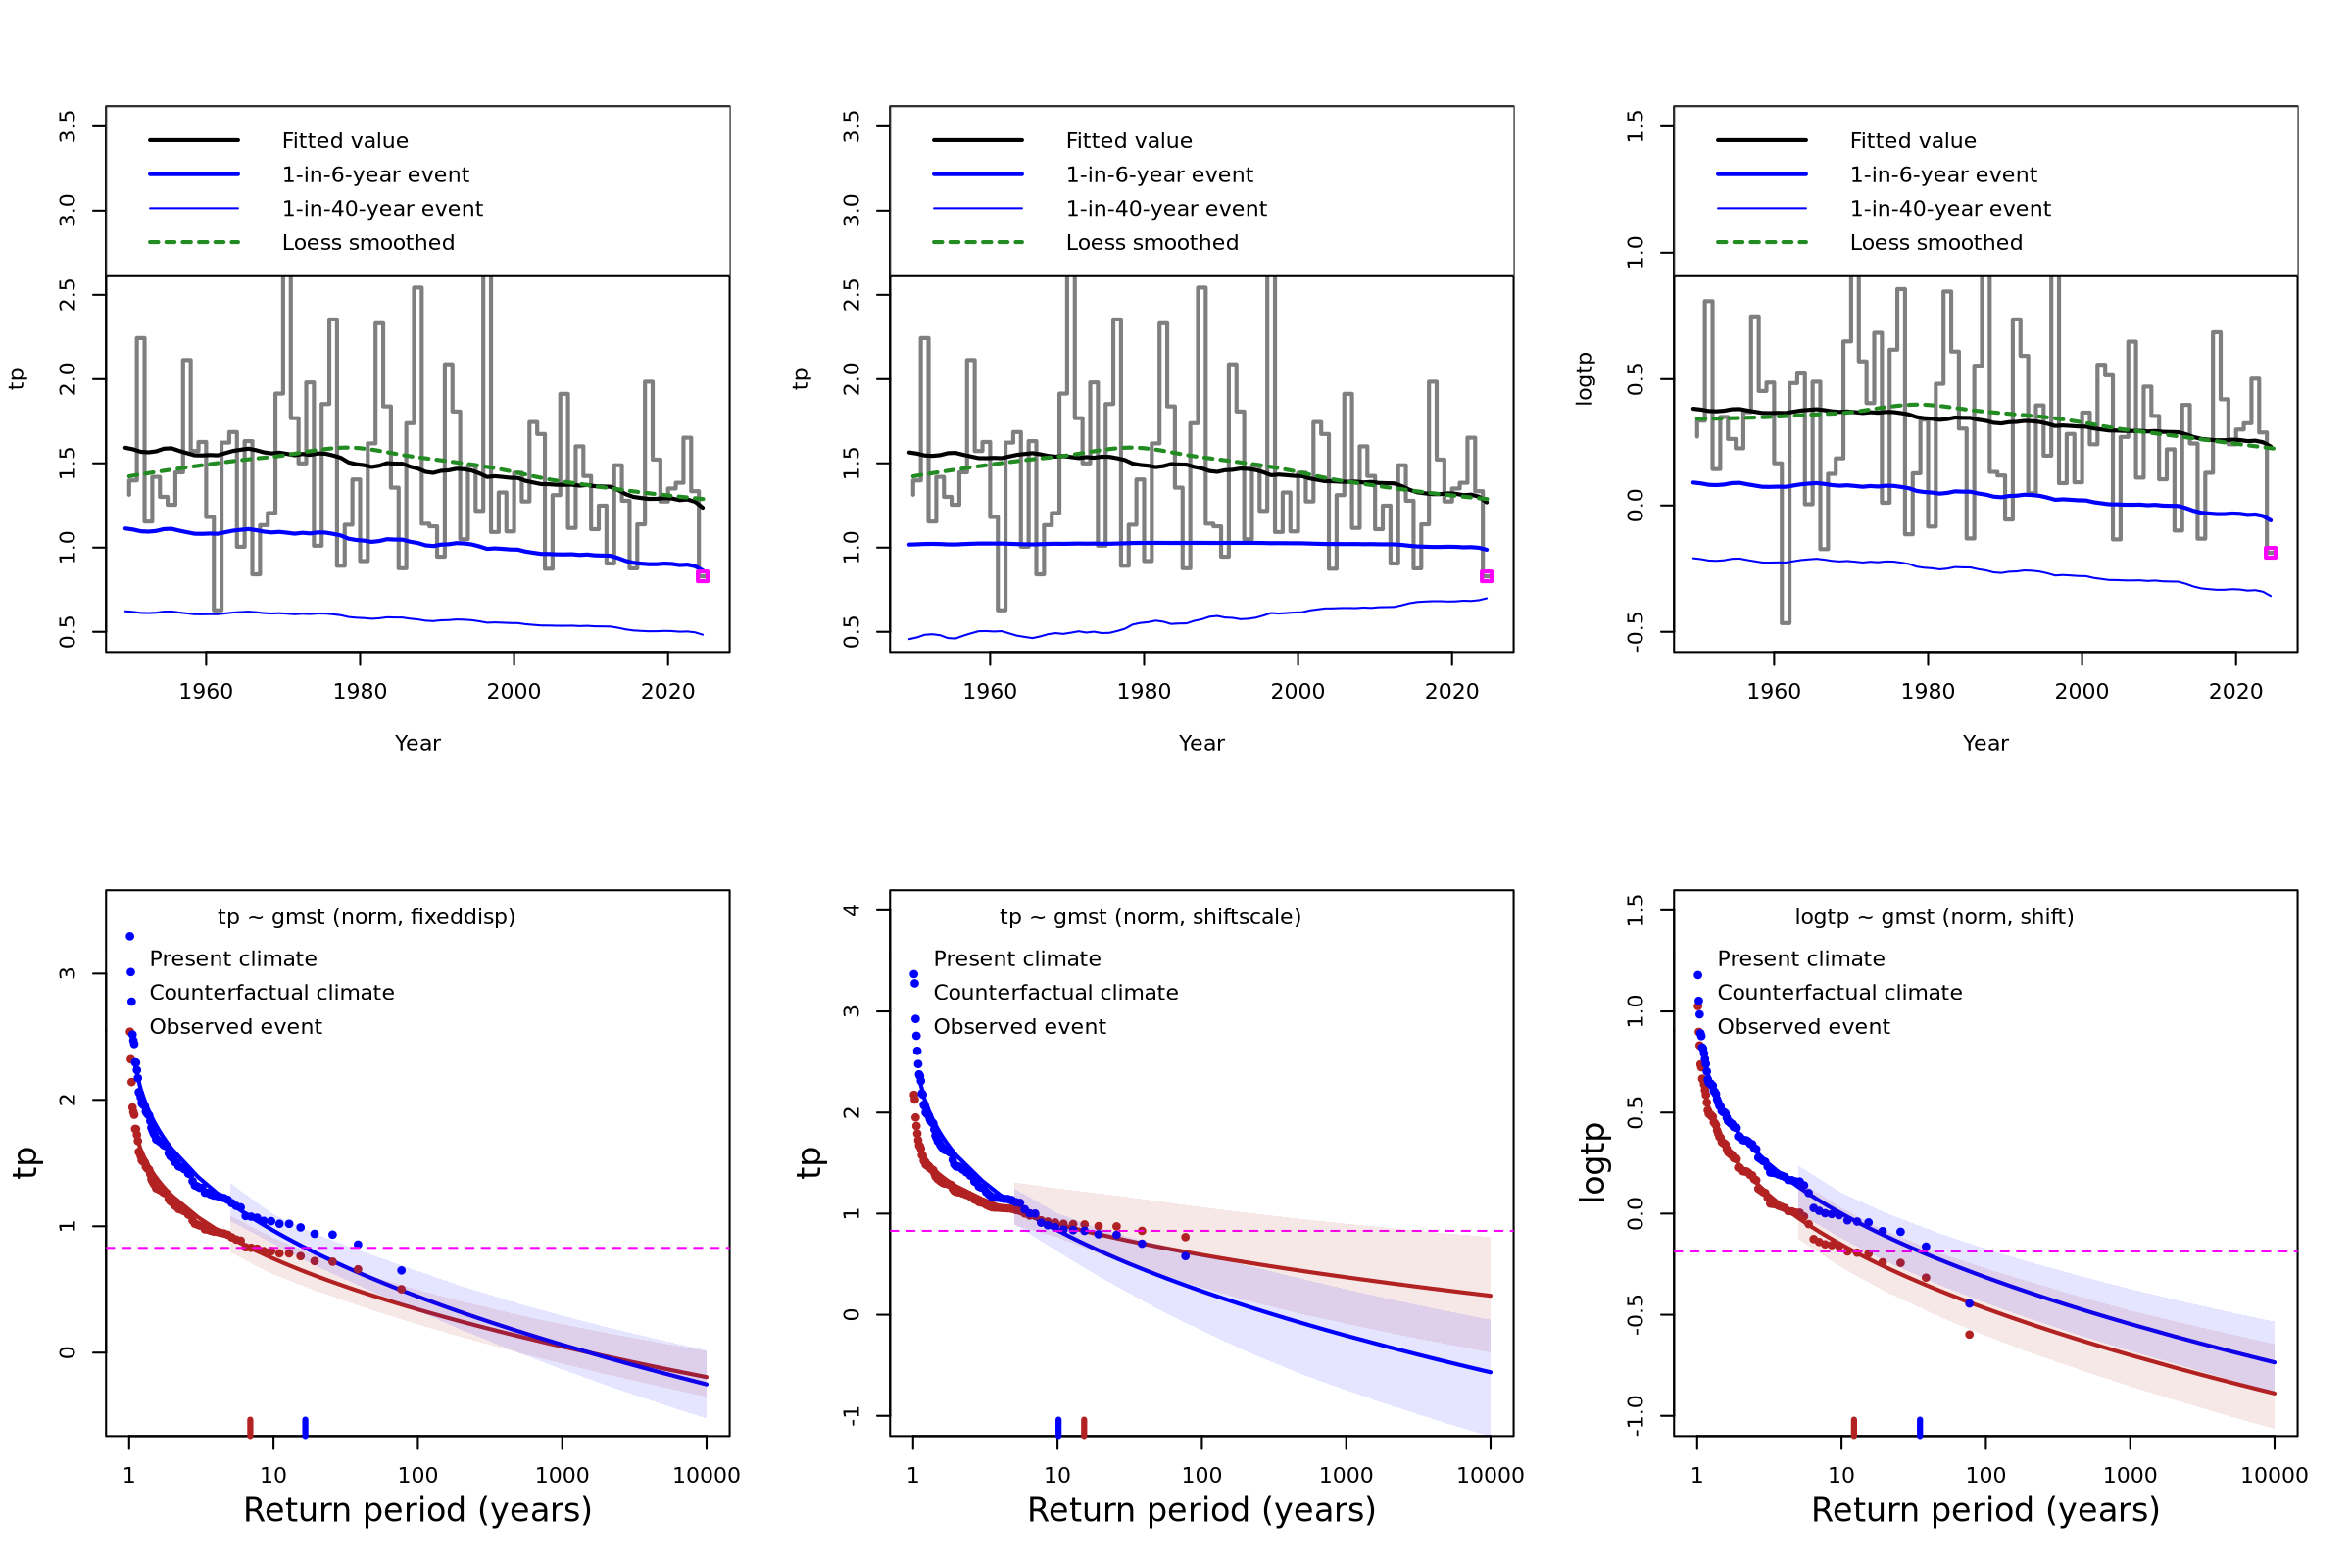

In [ ]:
prep_window(c(2,3))

plot_trend(mdl_norm)
plot_trend(mdl_normss)
plot_trend(mdl_normlog)

plot_returnlevels(mdl_norm, cov_f = cov_2024, cov_cf = cov_cf, nsamp = 50)
plot_returnlevels(mdl_normss, cov_f = cov_2024, cov_cf = cov_cf, nsamp = 50)
plot_returnlevels(mdl_normlog, cov_f = cov_2024, cov_cf = cov_cf, nsamp = 50)

# Rework model plots

In [28]:
# load covariate data
gmst = read.table("gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2025]

# define factual & counterfactual covariates
cov_2024 <- gmst[gmst$year == 2025,"gmst", drop = F]
cov_cf <- rbind("pi" = cov_2024 - 1.3)

nsamp <- 1000

model_args <- list("dsr5x" = list(dist = "gev", type = "shift", lower = F),
                   "dsr10x" = list(dist = "gev", type = "shift", lower = F),
                   "dsr16x" = list(dist = "gev", type = "shift", lower = F),
                   "tx10x" = list(dist = "gev", type = "shift", lower = F),
                   "tx10x-iberia" = list(dist = "gev", type = "shift", lower = F),
                   "tx10x-spain" = list(dist = "gev", type = "shift", lower = F),
                   "tg10x-iberia" = list(dist = "gev", type = "shift", lower = F),
                   "tas-jja" = list(dist = "norm", type = "shift", lower = F),
                   "pr-jja" = list(dist = "norm_logt", type = "shift", lower = T)
                  )

## Bootstrap all results

In [29]:
for (varnm in names(model_args)) {

    res_fnm = paste0("res/boot",nsamp,"_",varnm,".csv")
    if (file.exists(res_fnm)) next
    
    df <- merge(gmst, read.csv(paste0("ts/",varnm,".csv"), col.names = c("year", "x")))
    mdl <- do.call(fit_ns, append(model_args[[varnm]], list(data = df, covnm = "gmst", varnm = "x")))
    boot_res <- boot_ci(mdl, cov_f = cov_2024, cov_cf = cov_cf, nsamp = nsamp)
    write.csv(boot_res, res_fnm)
    
    # mdl_gev <- fit_ns("gev", "shift", data = df, varnm = "x", covnm = "gmst", lower = F)
    # mdl_lnorm <- fit_ns("norm_logt", "shift", data = df, varnm = "x", covnm = "gmst", lower = F)

    # gev_ci <- boot_ci(mdl_gev, cov_f = cov_2024, cov_cf = cov_cf, nsamp = 1000)
    # lnorm_ci <- boot_ci(mdl_lnorm, cov_f = cov_2024, cov_cf = cov_cf, nsamp = 1000)
    # write.csv(gev_ci, paste0("res/boot1000_",varnm,"_gev.csv"))
    # write.csv(lnorm_ci, paste0("res/boot1000_",varnm,"_lnorm.csv"))
}

In [33]:
# compile results
fl <- list.files("res", full.names = T)
res <- plyr::rbind.fill(sapply(fl, function(fnm) {
    boot_res <- read.csv(fnm, row.names = "X")
    data.frame(c(unlist(lapply(rownames(boot_res)[1:(nrow(boot_res)-1)], function(cnm) setNames(boot_res[cnm,], paste(gsub("_", "-", cnm), c("est", "lower", "upper"), sep = "_")))),
                setNames(boot_res[nrow(boot_res),], c("nobs", "nsamp", "nfailed"))))
}, simplify = F))
rownames(res) <- gsub(".csv","",sapply(strsplit(fl, "_"), "[", 2))
res <- res[c("dsr5x", "dsr10x", "dsr16x", "tx10x", "tx10x-spain", "tx10x-iberia", "tg10x-iberia", "tas-jja", "pr-jja"),]
write.csv(res, "res-compiled.csv")

In [34]:
res <- read.csv("res-compiled.csv", row.names = "X")

In [35]:
sapply(c("event.magnitude", "return.period","dI.rel", "dI.abs", "PR"), function(cnm) {
    apply(signif(res, 3)[,grepl(cnm, colnames(res))], 1, function(r) paste0(r[1], " (",r[2], ", ", r[3], ")"))
})

,event.magnitude,return.period,dI.rel,dI.abs,PR
dsr5x,"12.3 (12.3, 12.3)","8.58 (4.28, 32.5)","30.9 (10.7, 56.1)","2.9 (1.18, 4.42)","21.3 (3.52, Inf)"
dsr10x,"11.9 (11.9, 11.9)","15.2 (6.67, 162)","29.4 (9.1, 56.8)","2.7 (0.991, 4.3)","38.7 (4.36, Inf)"
dsr16x,"10.7 (10.7, 10.7)","27.9 (9.54, Inf)","29.2 (9.42, 56.1)","2.43 (0.925, 3.86)","154 (6.8, Inf)"
tx10x,"32.5 (32.5, 32.5)","13.3 (5.21, 187)","10.7 (6.17, 15.7)","3.14 (1.89, 4.41)","221 (7.61, Inf)"
tx10x-spain,"35.3 (35.3, 35.3)","20.3 (6.59, 10100)","12.2 (8.73, 16.1)","3.85 (2.83, 4.89)","Inf (Inf, Inf)"
tx10x-iberia,"35.3 (35.3, 35.3)","18.6 (6.18, Inf)","11.9 (8.58, 15.3)","3.75 (2.79, 4.69)","Inf (1.02e+12, Inf)"
tg10x-iberia,"27.4 (27.4, 27.4)","4.71 (2.46, 13.1)","14 (10.5, 17.5)","3.36 (2.6, 4.08)","Inf (306, Inf)"
tas-jja,"27 (27, 27)","11.1 (4.79, 49.3)","12.1 (8.23, 15.9)","2.91 (2.05, 3.71)","3660 (399, 177000)"
pr-jja,"0.787 (0.787, 0.787)","11.2 (5.24, 39.7)","-15.2 (-33, 9.31)","-0.141 (-0.388, 0.0671)","3.01 (0.529, 17.6)"


## Model selection

In [7]:
varnm <- "dsr16x"

ylim <- list("tx10x" = c(24,38), "dsr5x" = c(2,17), "dsr10x" = c(2,17), "dsr16x" = c(2,17))[[varnm]]

df <- merge(gmst, read.csv(paste0("ts/",varnm,".csv"), col.names = c("year", varnm)))

mdl_gev <- fit_ns("gev", "shift", data = df, varnm = varnm, covnm = "gmst", lower = F)
mdl_lnorm <- fit_ns("norm_logt", "shift", data = df, varnm = varnm, covnm = "gmst", lower = F)

png(paste0("fig/model-output_",varnm,"_gev.png"), height = 360, width = 360 * 3); {
    prep_window(c(1,3))
    plot_trend(mdl_gev, ylim = ylim)
    plot_covtrend(mdl_gev, xcov = "gmst", ylim = ylim)
    plot_returnlevels(mdl_gev, cov_f = cov_2024, cov_cf = cov_cf, nsamp = 10, ylim = ylim)
}; dev.off()

png(paste0("fig/model-output_",varnm,"_lnorm.png"), height = 360, width = 360 * 3); {
    prep_window(c(1,3))
    plot_trend(mdl_lnorm, ylim = ylim)
    plot_covtrend(mdl_lnorm, xcov = "gmst", ylim = ylim)
    plot_returnlevels(mdl_lnorm, cov_f = cov_2024, cov_cf = cov_cf, nsamp = 10, ylim = ylim)
}; dev.off()

agg_record_27159513 
                  2

agg_record_27159513 
                  2

# 10-day heat over Iberia

In [17]:
varnm <- "tx10x"

gmst = read.table("gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2025]

# define factual & counterfactual covariates
cov_2024 <- gmst[gmst$year == 2025,"gmst", drop = F]
cov_cf <- rbind("pi" = cov_2024 - 1.3)

df <- merge(gmst, read.csv(paste0("ts/",varnm,"-iberia.csv"), col.names = c("year", varnm)))

In [18]:
mdl <- fit_ns("gev", "shift", df, varnm = varnm, covnm = "gmst", lower = F)

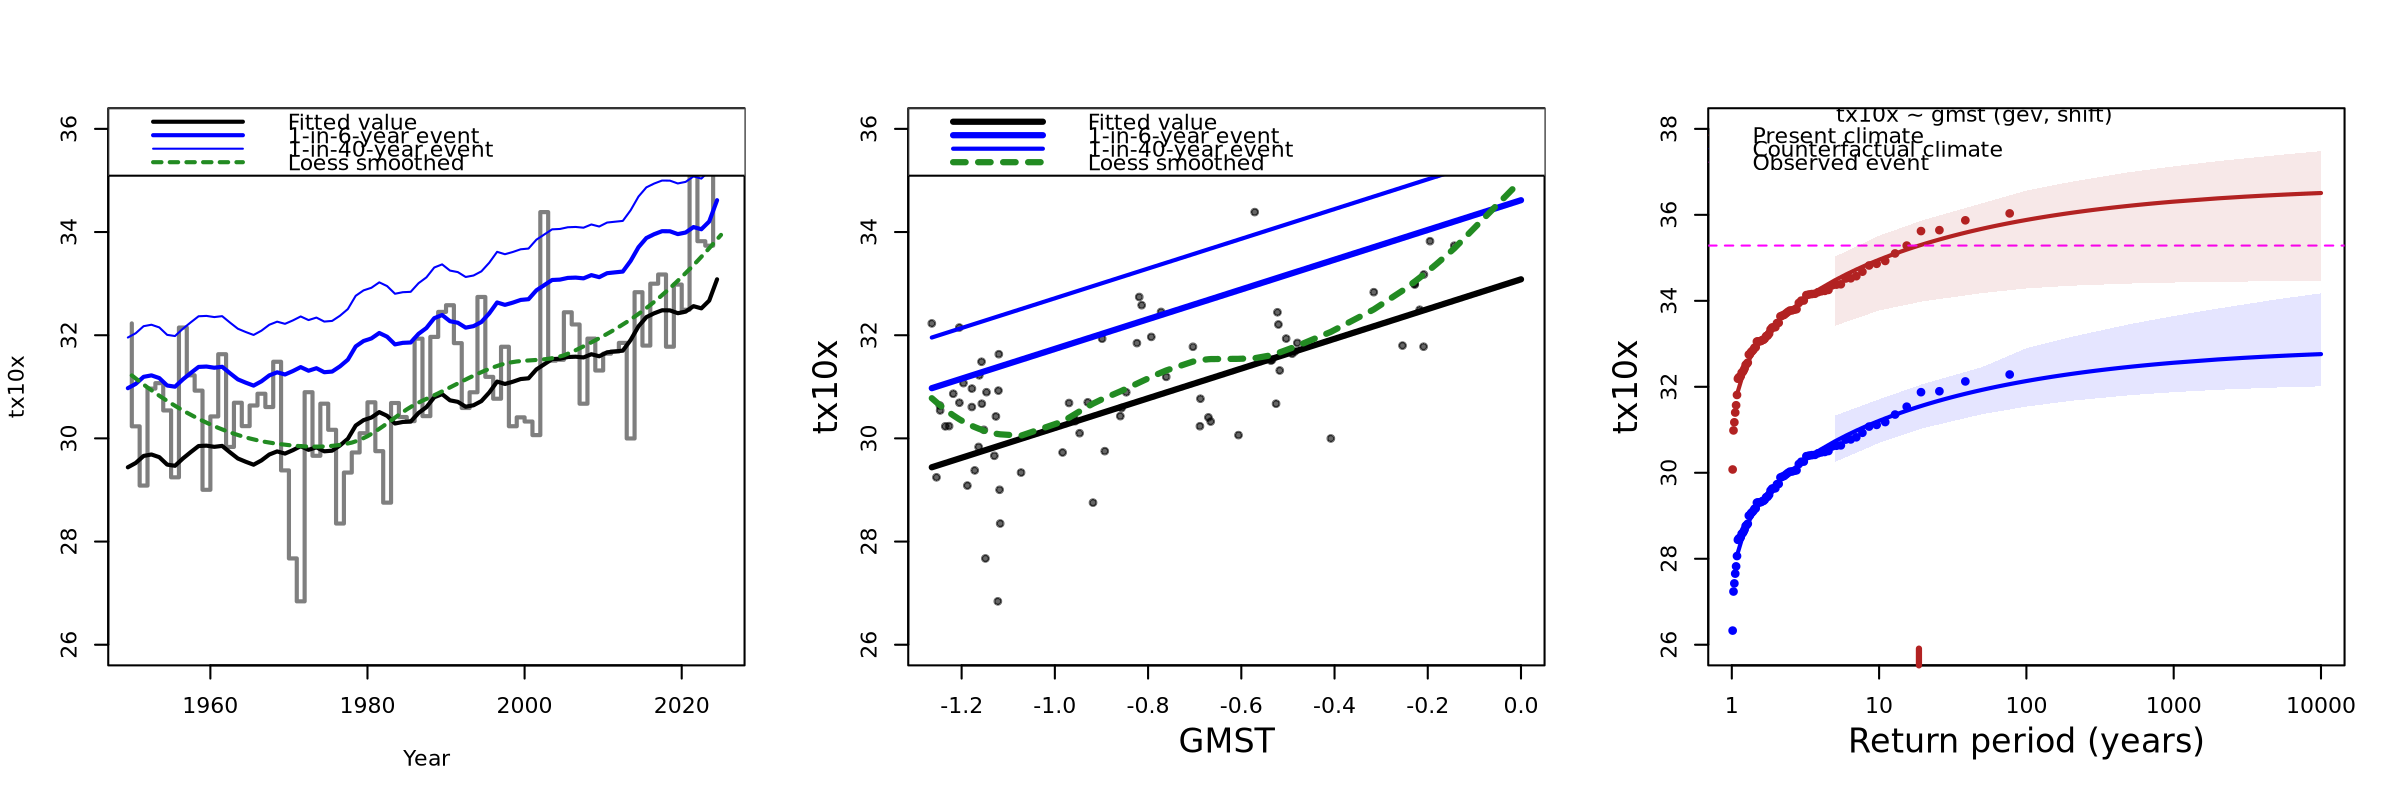

In [20]:
prep_window(c(1,3))

plot_trend(mdl)
plot_covtrend(mdl, "gmst")
plot_returnlevels(mdl, cov_f = cov_2024, cov_cf = cov_cf, nsamp = 50)